In [19]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
# pip install pandas-profiling
import pandas_profiling as pdp
import seaborn as sns

import time

traps = pd.read_csv('assets/train.csv')
spray = pd.read_csv('assets/spray.csv')
weather = pd.read_csv('assets/weather.csv')

# Preliminary EDA

In [27]:
# pdp.ProfileReport(traps)
# pdp.ProfileReport(spray)
# pdp.ProfileReport(weather)

# sns.pairplot(traps)
# sns.pairplot(spray)
# sns.pairplot(weather)

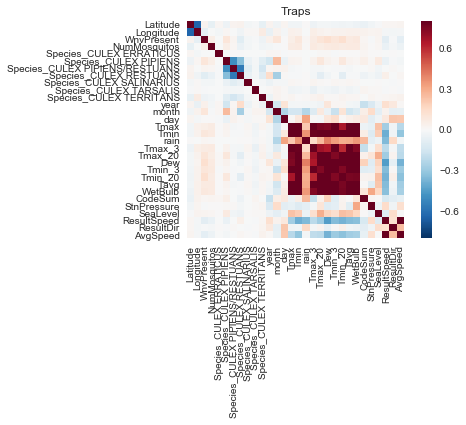

In [35]:
def find_correlation(data,title):
    correlation = data.corr()
    sns.heatmap(correlation, vmax=.8, square=True)
    plt.title(title)

find_correlation(traps, 'Traps')

In [29]:
traps.Species.value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [8]:
traps.isnull().sum()

Trap                              0
Latitude                          0
Longitude                         0
Date                              0
WnvPresent                        0
NumMosquitos                      0
Species_CULEX ERRATICUS           0
Species_CULEX PIPIENS             0
Species_CULEX PIPIENS/RESTUANS    0
Species_CULEX RESTUANS            0
Species_CULEX SALINARIUS          0
Species_CULEX TARSALIS            0
Species_CULEX TERRITANS           0
year                              0
month                             0
day                               0
Tmax                              0
Tmin                              0
rain                              0
Tmax_3                            0
Tmax_20                           0
Dew                               0
Tmin_3                            0
Tmin_20                           0
Tavg                              0
WetBulb                           0
CodeSum                           0
StnPressure                 

In [9]:
traps.duplicated().sum()

0

Yikes. Thats quite a few duplicates. We know from the data descriptions that observations are capped at 50 mosquitos, so it's definitely possible that a single observation spans a couple of records. We'll leave the duplicates for this reason, and sum up the number of mosquitos.

In [30]:
weather.head(2)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6


In [21]:
weather.Station.value_counts()

1    1472
2    1472
Name: Station, dtype: int64

The weather data has 2 weather observations per date, one from station 1 and the other from station 2. Maybe we only need data from one station. Let's compare the number of missing values, == 'M', by station.

In [13]:
weather.dtypes

Station                 int64
Date           datetime64[ns]
Tmax                    int64
Tmin                    int64
Tavg                  float64
Depart                 object
DewPoint                int64
WetBulb               float64
Heat                   object
Cool                   object
Sunrise                object
Sunset                 object
CodeSum                object
Depth                  object
Water1                 object
SnowFall               object
PrecipTotal           float64
StnPressure           float64
SeaLevel              float64
ResultSpeed           float64
ResultDir               int64
AvgSpeed              float64
dtype: object

In [22]:
# skip the numeric columns, because they can't contain the 'M' string
check_missing_values = ['Depart','Heat','Cool','Sunrise','Sunset','Depth','Water1','SnowFall']
for col in weather[check_missing_values]:
    station_1 = len(weather[(weather[col].str.contains('\D')) & (weather.Station==1)])
    print col + ' has ' + str(station_1) + ' missing values at station 1'
    station_2 = len(weather[(weather[col].str.contains('\D')) & (weather.Station==2)])
    print col + ' has ' + str(station_2) + ' missing values at station 2'


Depart has 1271 missing values at station 1
Depart has 1472 missing values at station 2
Heat has 0 missing values at station 1
Heat has 11 missing values at station 2
Cool has 1096 missing values at station 1
Cool has 1021 missing values at station 2
Sunrise has 0 missing values at station 1
Sunrise has 1472 missing values at station 2
Sunset has 0 missing values at station 1
Sunset has 1472 missing values at station 2
Depth has 0 missing values at station 1
Depth has 1472 missing values at station 2
Water1 has 1472 missing values at station 1
Water1 has 1472 missing values at station 2
SnowFall has 1472 missing values at station 1
SnowFall has 1472 missing values at station 2


It looks like station 2 consistently has more missing values, so let's stick to using station 1 as our weather source.

In [23]:
weather = weather[weather.Station==1]

In [24]:
weather.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

# Data Transformation

## Modify columns

In [2]:
import datetime
# Convert Date columns to actual date data type
traps.Date = pd.to_datetime(traps.Date)
spray.Date = pd.to_datetime(spray.Date)
weather.Date = pd.to_datetime(weather.Date)

In [3]:
# Weather data:

# weather data has two records per date-- station 1, station 2
# station 2 seems to have more missing values, so choose all from station 1
weather = weather[weather.Station==1]


# the PrecipTotal column contains the letter 'T' in some rows
# this indicates a 'trace' amount of precipitation, which is
# defined as less than 0.005
# 'M' indicates missing data

def clean_col(column):
    weather[column] = weather[column].str.replace('T','0.005')
    weather[column] = weather[column].str.replace('M','0.0')
    weather[column] = weather[column].astype(float)

clean_col('Tavg')
clean_col('PrecipTotal')
clean_col('WetBulb')
clean_col('StnPressure')
clean_col('SeaLevel')
clean_col('AvgSpeed')

weather.CodeSum = weather.CodeSum.str.strip()
weather.CodeSum[weather.CodeSum.str.contains('^\w')] = '1'
weather.CodeSum[weather.CodeSum!='1'] = '0'
weather['Tavg'][weather.Tavg==0] = (weather.Tmin + weather.Tmax) / 2


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Grouping records from same trap, same day inspection

In [4]:
# Because records are capped at 50 mosquitos,
# we are grouping the data to obtain a unique
# observation record per trap per date, with
# a total sum of NumMosquitos

traps = traps[['Trap',
               'Latitude',
               'Longitude',
               'Date',
               'Species',
               'WnvPresent',
               'NumMosquitos']].groupby(['Trap',
                                         'Latitude',
                                         'Longitude',
                                         'Date', 
                                         'Species',
                                         'WnvPresent']).agg({'NumMosquitos':np.sum}).reset_index()

## get species dummies and add to traps df
traps = pd.get_dummies(traps, columns=['Species'])

## Parse Dates
traps['year']=traps['Date'].dt.year
traps['month']=traps['Date'].dt.month
traps['day']=traps['Date'].dt.day


## Applying the weather data to the dataframe

In [5]:
## This function takes three arguments:
## The column name as a string from weather dataframe that we want to extract
## a numpy function that we want to do to the data
## an integer number of previous days to extract

def weather_add(df, weather_col, func, days_range=7):
    new_list = []
    for i in df['Date']:
        mask = (weather['Date'] <= i) & (weather['Date'] >= i - pd.Timedelta(days=days_range))
        data_list = func(weather[weather_col][mask])
        new_list.append(data_list)
    return new_list

In [6]:
## running this cell will extract the average temp min, average temp max, and precipitation sum 
## to the traps dataframe from the previous 7 days, unless otherwise specified

traps['Tmax']    = weather_add(traps, weather_col='Tmax', func=np.mean)
traps['Tmin']    = weather_add(traps, weather_col='Tmin', func=np.mean)
traps['rain']    = weather_add(traps, weather_col='PrecipTotal', func= np.sum)
traps['Tmax_3']  = weather_add(traps, weather_col='Tmax', func=np.mean, days_range=3)
traps['Tmax_20'] = weather_add(traps, weather_col='Tmax',func=np.mean, days_range=20)
traps['Dew']     = weather_add(traps, weather_col ='DewPoint', func=np.mean, days_range = 10)
traps['Tmin_3']  = weather_add(traps, weather_col='Tmin', func=np.mean, days_range=3)
traps['Tmin_20'] = weather_add(traps, weather_col='Tmin', func=np.mean, days_range=20)

for col in ['Tavg','WetBulb','CodeSum','StnPressure','SeaLevel', 'ResultSpeed', 'ResultDir','AvgSpeed']:
    traps[col] = weather_add(traps, weather_col=col, func=np.mean)

In [34]:
## Check out how the correlation map changes with our new features
find_correlation(traps, 'Traps')

NameError: name 'find_correlation' is not defined

## Scale the Data 

In [39]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

features = traps.columns.drop(['Date','Trap','WnvPresent','NumMosquitos'])

# create a new df for each scaling procedure
traps_mm =  pd.DataFrame(MinMaxScaler().fit_transform(traps[features]),columns=features)
traps_r =  pd.DataFrame(MinMaxScaler().fit_transform(traps[features]),columns=features)
traps_s =  pd.DataFrame(MinMaxScaler().fit_transform(traps[features]),columns=features)


In [7]:
## Save the transformed files so we don't have to run the earlier cells
traps.to_csv('./assets/Train_transformed/traps_jd.csv', encoding='utf-8', index=False)

In [73]:
##re-import the altered traps file
# traps = pd.read_csv('./assets/Train_transformed/traps_jd_425_2.csv')

# Feature Selection

In [66]:
traps.columns

Index([u'Address', u'Species', u'Block', u'Street', u'Trap',
       u'AddressNumberAndStreet', u'Latitude', u'Longitude',
       u'AddressAccuracy', u'NumMosquitos', u'WnvPresent', u'Tmax_x',
       u'Tmin_x', u'Tavg_x', u'Depart_x', u'DewPoint_x', u'WetBulb_x',
       u'Heat_x', u'Cool_x', u'Sunrise_x', u'Sunset_x', u'CodeSum_x',
       u'Depth_x', u'SnowFall_x', u'PrecipTotal_x', u'StnPressure_x',
       u'SeaLevel_x', u'ResultSpeed_x', u'ResultDir_x', u'AvgSpeed_x',
       u'Tmax_y', u'Tmin_y', u'Tavg_y', u'DewPoint_y', u'WetBulb_y', u'Heat_y',
       u'Cool_y', u'CodeSum_y', u'PrecipTotal_y', u'StnPressure_y',
       u'SeaLevel_y', u'ResultSpeed_y', u'ResultDir_y', u'AvgSpeed_y'],
      dtype='object')

In [67]:
# features = [
#     'rain','Tmax_3','Tmax', 'Dew', 'Tmin', 'Tmin_3', 'month'
# #             'WetBulb_y', 'StnPressure_y','AvgSpeed_y','Tmin_x','Tmax_x','PrecipTotal_x'
# #             'Latitude','Longitude',
# #             'CULEX ERRATICUS','CULEX PIPIENS','CULEX PIPIENS/RESTUANS','CULEX PIPIENS/RESTUANS',
# #            'CULEX SALINARIUS','CULEX TARSALIS','CULEX TERRITANS'
#            ]

In [40]:
X = traps[features]
y = traps.WnvPresent

# Train-Test Split

Creating a stratified train-test split to evaluate our model performance without having to submit to Kaggle every time

In [9]:
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.7, stratify=y)

In [43]:
print X_train.shape, X_test.shape, y_test.shape, y_train.shape

(2841, 30) (5769, 30) (5769,) (2841,)


Setting up scoring function

In [11]:
from sklearn.metrics import roc_auc_score

This function will return the roc score for some values of the model

In [12]:
def score_model(model):
    preds = [x[1] for x in model.predict_proba(X_test)]
    roc_score = roc_auc_score(y_test, preds)
    return roc_score

# Building the Models

## Random Forest

performs at .57
performs at .59 with Tmin, rain, Tmax_3 and Tmax_20

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [42]:
RF = RandomForestClassifier(n_estimators = 500, bootstrap=True, max_depth=None,
                            max_features='auto',min_samples_leaf= 1, min_samples_split= 2)

In [43]:
RF_model= RF.fit(X_train, y_train)

In [44]:
score_model(RF_model)

0.77841373671300096

### Random Forest Grid Search

In [50]:
grid_search_params = { 'max_features' : ['auto',None],
                    'max_depth':[None, 1, 5, 3],
                    'min_samples_split':[2,3,5],
                    'min_samples_leaf':[1,2,5],
                    'bootstrap':[True, False]
}

In [53]:
gs = GridSearchCV(RF, grid_search_params)

In [65]:
k = gs.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
k.best_params_

## Support Vector Machine

Currently performing at .50 (bad)

In [45]:
from sklearn.svm import SVC

In [46]:
svmc= SVC(probability=True)

In [47]:
svm_model = svmc.fit(X_train,y_train)

Train-Test Split Score

In [48]:
score_model(svm_model)

0.41450513574971204

## SVM Grid Search

In [ ]:
grid_search_params = { 'C' : [1,2,3.01,.001],
                    'kernel':['rbf', 'linear','poly']
}

In [ ]:
gsvm = GridSearchCV(svmc, grid_search_params, scoring = 'roc_auc')

In [ ]:
k = gsvm.fit(X,y)

In [ ]:
k.best_params_

## Logistic Regression

## ADA Boost

currently performs at .51

In [49]:
from sklearn.ensemble import AdaBoostClassifier

In [50]:
adaboost= AdaBoostClassifier()

In [52]:
ada_model=adaboost.fit(X_train,y_train)

In [58]:
ada_model.score(X_train,y_train)

0.9457441513190642

## XG Boost

In [54]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier  
import scipy.stats as st


In [55]:
model = XGBClassifier()

In [56]:
xgm = model.fit(X_train, y_train, eval_metric=roc_auc_score)

In [17]:
xg_preds = xgm.predict_proba(X_test)

In [57]:
score_model(xgm)

0.86553347935852376

In [19]:
import random

params = {  
#     "n_estimators": st.randint(3, 40),
    "n_estimators": [5,1,4,7]
#     ,
#     "max_depth": st.randint(3, 40)
#     ,
#     "learning_rate": st.uniform(0.05, 0.4)
#     ,
#     "objective":'binary:logistic'
}
xgbclass = XGBClassifier()  


In [22]:
from sklearn.model_selection import RandomizedSearchCV

gs = GridSearchCV(xgbclass, params, n_jobs=-1, scoring='roc_auc')  


In [23]:
gs.fit(X_train, y_train)  


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [5, 1, 4, 7]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

In [110]:
gs.best_estimator_

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=7, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [24]:
xg_grid = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


In [25]:
xg_final = xg_grid.fit(X_train, y_train)

In [26]:
score_model(xg_final)

0.88542593001533854

In [34]:
param = {}

sum_wneg = len(traps[traps['WnvPresent']==0])
sum_wpos = len(traps[traps['WnvPresent']==1])

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(test_X)

# use logistic regression loss, use raw prediction before logistic transformation
# since we only need the rank
param['objective'] = 'binary:logitraw'
# scale weight of positive examples
param['scale_pos_weight'] = sum_wneg/sum_wpos
param['eta'] = 0.1
param['max_depth'] = 3
param['eval_metric'] = 'auc'
param['silent'] = 1
param['min_child_weight'] = 100
param['subsample'] = 0.7
param['colsample_bytree'] = 0.7
param['nthread'] = 4

num_round = 50

#xgb.cv(param, dtrain, num_round, nfold=5)

bst = xgb.train(param, dtrain, num_round)

#print "testing"
ypred = bst.predict(dtest)


NameError: name 'test_X' is not defined

In [192]:
def sigmoid(x):
    return 1.0 / (1.0 + math.exp(-x))


In [193]:
ypred

array([-2.80704665, -2.80704665, -2.80704665, ..., -1.13581872,
       -1.13581872, -1.13581872], dtype=float32)

In [194]:
ypreds = []
for x in np.nditer(ypred):
    ypreds.append(sigmoid(x))
ypreds

[0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.056944573812919154,
 0.05694457

In [195]:
indexes=np.arange(1, len(ypred)+1, 1)
xg_df = pd.DataFrame(data=[indexes, ypreds]).T
xg_df.columns =['Id','WnvPresent']
xg_df['Id'] = xg_df.Id.astype(int)
xg_df.to_csv('./submissions/xg_best.csv', index=False)

# Import and Transform Test Data

In [27]:
test = pd.read_csv('assets/test.csv')

In [28]:
### converting datetime

test.Date = pd.to_datetime(test.Date)

## get species dummies and add to traps df
test = pd.get_dummies(test, columns=['Species'])

## Parse Dates
test['year']=test['Date'].dt.year
test['month']=test['Date'].dt.month
test['day']=test['Date'].dt.day



In [32]:
## Applying weather data
test['Tmax'] = weather_add(test, weather_col='Tmax', func=np.mean)
test['Tmin'] = weather_add(test, weather_col='Tmin', func=np.mean)
test['rain'] = weather_add(test, weather_col='PrecipTotal', func= np.sum)
test['Tmax_3'] = weather_add(test, weather_col='Tmax', func=np.mean, days_range=3)
test['Tmax_20'] = weather_add(test, weather_col='Tmax',func=np.mean, days_range=20)
test['Dew']= weather_add(test, weather_col ='DewPoint', func=np.mean, days_range = 10)
test['Tmin_3'] = weather_add(test, weather_col='Tmin', func=np.mean, days_range=3)
test['Tmin_20'] = weather_add(test, weather_col='Tmin', func=np.mean, days_range=20)

for col in ['Tavg','WetBulb','CodeSum','StnPressure','SeaLevel', 'ResultSpeed', 'ResultDir','AvgSpeed']:
    test[col] = weather_add(test, weather_col=col, func=np.mean)


In [64]:
test['Dew_20']= weather_add(test, weather_col ='DewPoint', func=np.mean, days_range = 20)
test['Tavg_20'] = weather_add(test, weather_col='Tavg', func=np.mean, days_range=20)
test['WetBulb_20'] = weather_add(test, weather_col='WetBulb', func=np.mean, days_range=20)
test['CodeSum_20'] = weather_add(test, weather_col='CodeSum', func=np.mean, days_range=20)
test['StnPressure_20'] = weather_add(test, weather_col='StnPressure', func=np.mean, days_range=20)
test['SeaLevel_20'] = weather_add(test, weather_col='SeaLevel', func=np.mean, days_range=20)
test['ResultSpeed_20'] = weather_add(test, weather_col='ResultSpeed', func=np.mean, days_range=20)
test['ResultDir_20'] = weather_add(test, weather_col='ResultDir', func=np.mean, days_range=20)
test['AvgSpeed_20'] = weather_add(test, weather_col='AvgSpeed', func=np.mean, days_range=20)

In [65]:
## Export the tranformed test data to a folder in the repo 
## so we don't have to run the above cells every time

test.to_csv('./assets/Test_transformed/test_transformed_jd_2.csv',sep=',', encoding='utf-8')

In [4]:
test = pd.read_csv('./assets/Test_transformed/test_transformed_jd.csv')

In [ ]:
test.head(2)

In [36]:
features

Index([u'Latitude', u'Longitude', u'NumMosquitos', u'Species_CULEX ERRATICUS',
       u'Species_CULEX PIPIENS', u'Species_CULEX PIPIENS/RESTUANS',
       u'Species_CULEX RESTUANS', u'Species_CULEX SALINARIUS',
       u'Species_CULEX TARSALIS', u'Species_CULEX TERRITANS', u'year',
       u'month', u'day', u'Tmax', u'Tmin', u'rain', u'Tmax_3', u'Tmax_20',
       u'Dew', u'Tmin_3', u'Tmin_20', u'Tavg', u'WetBulb', u'CodeSum',
       u'StnPressure', u'SeaLevel', u'ResultSpeed', u'ResultDir', u'AvgSpeed'],
      dtype='object')

In [34]:
test_X = test[features]

# Exporting to test

In [33]:
###This function will takes a model and a model name(as a string), generate predictions, 
### and save that as a CSV labeled with the model name and date.
import time 
import math
def model_and_export(model, model_name):
    pred_list = []
#     predictions = ["%.1f" % (math.ceil(x[1] * 100) / 100) for x in model.predict_proba(test_X)]
    predictions =  model.predict_proba(test_X)
    for x in predictions:
        pred_list.append(x[1])
    indexes=np.arange(1, len(predictions)+1, 1)
    preds_df = pd.DataFrame(data=[indexes, pred_list]).T
    preds_df.columns =['Id','WnvPresent']
    preds_df['Id'] = preds_df.Id.astype(int)
    location = './submissions/{}_{}.csv'.format(model_name, time.strftime("%d_%m_%Y"))
    preds_df.to_csv(location, index=False)
    return
    

In [203]:
model_and_export(RF_model, 'RF_test')

In [ ]:
model_and_export(svm_model, 'SVM')

In [ ]:
model_and_export(ada_model, 'ADABoost')

In [35]:
model_and_export(xgm, 'XG')
#. 4

In [112]:
model_and_export(xg_final, 'XW')

You can test the model by submitting the results CSV to :

https://www.kaggle.com/c/predict-west-nile-virus/submit

please note that only 5 submission can be made per day. 

Make note of the model and score below:


